# Gesture Recognition

Create a model to detect gestures to control the Smart-TV without remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

### Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

# Library Import

In [1]:
import numpy as np
import os
import PIL
import imageio.v2 as imageio
from imageio import imread
import cv2
import datetime
import os
import abc
from tensorflow.keras.optimizers import SGD, Adam

import warnings
warnings.filterwarnings("ignore")

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# project_folder = '../Gesture_Recognition/Project_data/'
project_folder = '/datasets/Project_data/'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
batch_size = 25 #added

In [5]:
num_epochs = 50 # added # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 50


# Parent class declaration

In [6]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [7]:
class ModelBuilderClass(metaclass = abc.ABCMeta):
    def __init__(self, file_start = ""):
        self.file_start = file_start
        

      # initialize the path of data folder
    def initialize_path(self, project_folder):
        # read the folder names for training and validation
        self.train_doc = np.random.permutation(open(project_folder+'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder+'val.csv').readlines())
        self.train_path = project_folder+'train'
        self.val_path = project_folder+'val'
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)

      # initialize the different properties of image
    def initialize_image_properties(self,image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

      # initialize hyperparameters of model
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs=num_epochs

      # Generator for the model
      ### This is one of the most important part of the code. The overall structure of the generator has been given.
      ### In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as
      ### create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.
    def generator(self,source_path, folder_list, shuffle=True, augment=False):
        batch_size = self.batch_size
        print('Source path = ', source_path, '; batch size =', batch_size)
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        #print('img_idx - ', img_idx)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
            #print('num_batches - ',num_batches)
            for batch in range(num_batches):
                #print('batch - ',batch)
                batch_data = np.zeros((batch_size, len(img_idx), self.image_width, self.image_height, self.channels))
                batch_labels = np.zeros((batch_size, 5))
                for folder in range(batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                    for idx, item in enumerate(img_idx):
                        #print('idx - ', idx, 'item - ',item)
                        #print(t[folder + (batch*batch_size)].strip())
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image_resized = cv2.resize(image, (self.image_height, self.image_width))
                        #print('folder - ', folder, ' idx - ',idx)
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)

                        batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                        batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                        batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels
            #print('Remaining ------------------------------------- ')
            if len(t) % batch_size != 0:
                remaining_batch_size = len(t) % batch_size
                batch_data = np.zeros((remaining_batch_size, len(img_idx), self.image_width, self.image_height, self.channels))
                batch_labels = np.zeros((remaining_batch_size, 5))
                for folder in range(remaining_batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                    for idx, item in enumerate(img_idx):
                        #print('folder - ', folder, ' idx - ',idx)
                        image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image_resized = cv2.resize(image, (self.image_height, self.image_width))
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)

                        batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                        batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                        batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                    batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels
                
    # Method to train model
    def train_model(self, model, augment_data=False):
        curr_dt_time = datetime.datetime.now()

        # create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc, augment=augment_data)

        model_name = self.file_start + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # Callbacks
        checkpoint = ModelCheckpoint(
            filepath, 
            monitor='val_loss', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            save_freq='epoch')
        LR = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            verbose=1, 
            patience=4)
        earlyStop = tf.keras.callbacks.EarlyStopping(
            patience=6, 
            min_delta=0.001, 
            monitor="val_loss", 
            restore_best_weights=True)
        callbacks_list = [checkpoint, LR, earlyStop]

        # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
        if (self.num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//batch_size) + 1

        if (self.num_val_sequences%batch_size) == 0:
            validation_steps = int(self.num_val_sequences/batch_size)
        else:
            validation_steps = (self.num_val_sequences//batch_size) + 1

        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                callbacks=callbacks_list, validation_data=val_generator,
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

      # Abstract method to define the model
    @abc.abstractmethod
    def define_model(self):
        pass


In [8]:
#Method to plot accuracy and loss
def plot_accuracy_and_loss(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Model 1 - Conv3D Model
- Conv3d (16, 32, 64, 128)
- Dense (128, 64, 5)
- hyperpapameter frames_to_sample=30, batch_size=20, num_epochs=20

In [9]:
# Model using Conv3D
class Conv3DModel1(ModelBuilderClass):

    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = SGD() #added #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [10]:
conv_3d1 = Conv3DModel1(file_start="1_conv3d_model1_")
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160, image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=20)
conv_3d1.generator(conv_3d1.val_path, conv_3d1.val_doc, augment=True)
conv_3d1_model = conv_3d1.define_model()


# training sequences = 663
# validation sequences = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 40, 40, 32)    0         


2023-12-30 12:38:01.759234: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-30 12:38:01.759300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
training_output_model1  = conv_3d1.train_model(conv_3d1_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20


2023-12-30 12:38:05.429997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 1.6152 - categorical_accuracy: 0.2000Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.61111, saving model to 1_conv3d_model1__2023-12-3012_38_01.869820/model-00001-1.61520-0.20000-1.61111-0.16250.h5
27/27 [==============================] - 61s 2s/step - loss: 1.6152 - categorical_accuracy: 0.2000 - val_loss: 1.6111 - val_categorical_accuracy: 0.1625 - lr: 0.0100
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.2065
Epoch 00002: val_loss improved from 1.61111 to 1.59784, saving model to 1_conv3d_model1__2023-12-3012_38_01.869820/model-00002-1.60882-0.20650-1.59784-0.20000.h5
27/27 [==============================] - 57s 2s/step - loss: 1.6088 - categorical_accuracy: 0.2065 - val_loss: 1.5978 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5977 - categorica

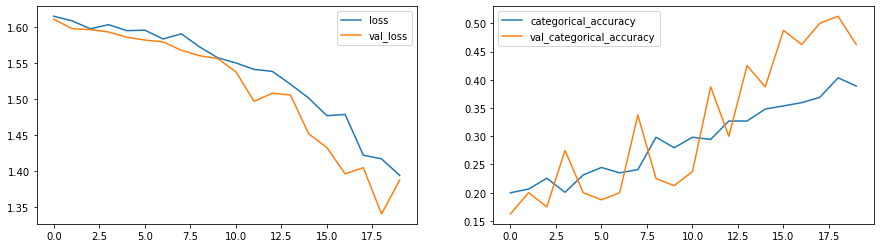

In [12]:
plot_accuracy_and_loss(training_output_model1)

## Observation Model 1 - Conv3D
- train_accuracy: 0.3889 
- val_accuracy: 0.4625
- Not much learning, also overfitting is observed

# Model 2 - Conv3D
- Conv3d(16, 16, 32, 32, 64, 128)
- Dense (128, 128, 5)
- frames_to_sample=30, batch_size=20, num_epochs=50

In [13]:
# Model using Conv3D
class Conv3DModel2(ModelBuilderClass):

    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv3D(32, (2, 2, 2), padding='same', activation='relu'))
        model.add(Dropout(0.25))
        model.add(Conv3D(32, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(128, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())

        model.add(Dense(128,activation='relu'))

        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = SGD() #added #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [14]:
conv_3d2 = Conv3DModel2(file_start="2_")
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160, image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=50)
conv_3d2.generator(conv_3d2.val_path, conv_3d2.val_doc, augment=True)
conv_3d2_model = conv_3d2.define_model()

# training sequences = 663
# validation sequences = 100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 conv3d_5 (Conv3D)           (None, 30, 160, 160, 16)  6928      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 80, 80, 16)    0         
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 dropout_3 (Dropout)         (None, 15, 80, 80, 32)    0        

In [15]:
training_output_model2  = conv_3d2.train_model(conv_3d2_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.6140 - categorical_accuracy: 0.2093Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60700, saving model to 2__2023-12-3012_57_17.543092/model-00001-1.61404-0.20926-1.60700-0.32500.h5
27/27 [==============================] - 111s 4s/step - loss: 1.6140 - categorical_accuracy: 0.2093 - val_loss: 1.6070 - val_categorical_accuracy: 0.3250 - lr: 0.0100
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.5995 - categorical_accuracy: 0.2084
Epoch 00002: val_loss improved from 1.60700 to 1.60461, saving model to 2__2023-12-3012_57_17.543092/model-00002-1.59954-0.20841-1.60461-0.26250.h5
27/27 [==============================] - 93s 4s/step - loss: 1.5995 - categorical_accuracy: 0.2084 - val_loss: 1.6046 - val_categorical_accuracy: 0.2625 - lr: 0.0100
Epoch 3/50
27/27 [=======================

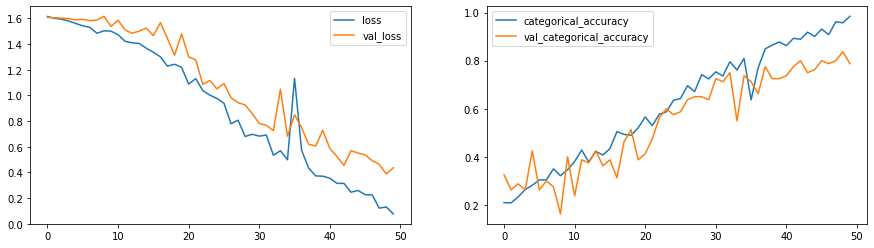

In [16]:
plot_accuracy_and_loss(training_output_model2)

## Observation Model 2 - Conv3D
- train_accuracy: 0.9847
- val_accuracy: 0.7875
- On adding more number of consecutive conv3d layers learning has imploved but overfitting still present

# Model 3 - Conv3D
- Conv3D (16, 16, 64, 128)
- Dense (128, 5)
- hyperparameters frames_to_sample=20, batch_size=20, num_epochs=50

In [17]:
# Model using Conv3D - less number of consequent conv layer, epoch = 30, batch_size = 20
class Conv3DModel3(ModelBuilderClass):
        
    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv3D(32, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv3D(128, (2, 2, 2), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = SGD() #added #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())
        return model

In [18]:
conv_3d3 = Conv3DModel3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=160, image_width=160)
conv_3d3.initialize_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=50)
conv_3d3.generator(conv_3d3.val_path, conv_3d3.val_doc, augment=True)
conv_3d3_model = conv_3d3.define_model()

# training sequences = 663
# validation sequences = 100
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 conv3d_11 (Conv3D)          (None, 20, 160, 160, 16)  6928      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 80, 80, 16)    0         
                                                                 
 conv3d_12 (Conv3D)          (None, 10, 80, 80, 32)    4128      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 40, 40, 32)    0        

In [19]:
training_output_model3  = conv_3d3.train_model(conv_3d3_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.6133 - categorical_accuracy: 0.1944Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60005, saving model to _2023-12-3014_13_52.372761/model-00001-1.61334-0.19444-1.60005-0.31250.h5
27/27 [==============================] - 64s 2s/step - loss: 1.6133 - categorical_accuracy: 0.1944 - val_loss: 1.6001 - val_categorical_accuracy: 0.3125 - lr: 0.0100
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.5807 - categorical_accuracy: 0.2333
Epoch 00002: val_loss improved from 1.60005 to 1.59344, saving model to _2023-12-3014_13_52.372761/model-00002-1.58071-0.23327-1.59344-0.37500.h5
27/27 [==============================] - 59s 2s/step - loss: 1.5807 - categorical_accuracy: 0.2333 - val_loss: 1.5934 - val_categorical_accuracy: 0.3750 - lr: 0.0100
Epoch 3/50
27/27 [============================

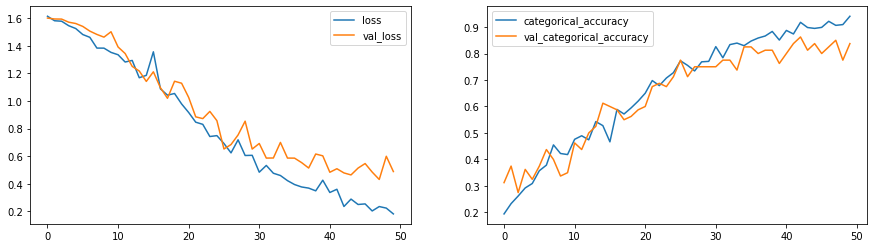

In [20]:
plot_accuracy_and_loss(training_output_model3)

## Observation Model 3 - Conv3D
- train_accuracy: 0.9407
- val_accuracy: 0.8375
- On reducing complexity and adding more dropouts, Train/Val accuracy improved with reduction in overfitting

# Model 4 - TimeDistributed Conv2D + LSTM
- Conv2D (16, 32, 64, 128, 256)
- LSTM (128)
- Dense (128, 5)
- Hyperparameters - frames_to_sample=30, batch_size=20, num_epochs=20

In [11]:
class CNNRNNModel(ModelBuilderClass):

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        optimiser = Adam(learning_rate=0.0002)
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [22]:
conv_cnn_rnn = CNNRNNModel(file_start="4_cnn-rnn_model_")
conv_cnn_rnn.initialize_path(project_folder)
conv_cnn_rnn.initialize_image_properties(image_height=160, image_width=160)
conv_cnn_rnn.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=20)
conv_cnn_rnn.generator(conv_cnn_rnn.val_path, conv_cnn_rnn.val_doc, augment=True)
conv_cnn_rnn_model = conv_cnn_rnn.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_cnn_rnn_model.summary()

# training sequences = 663
# validation sequences = 100
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 160, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 80, 80, 16)   0         
 tributed)                                                       
                                                                 
 dropout_10 (Dropout)        (None, 30, 80, 80, 16)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 80, 80, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 40, 40, 32)   0        

In [23]:
training_cnn_rnn_model  = conv_cnn_rnn.train_model(conv_cnn_rnn_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6414 - categorical_accuracy: 0.1963Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60623, saving model to 4_cnn-rnn_model__2023-12-3014_58_45.275967/model-00001-1.64140-0.19630-1.60623-0.21250.h5
27/27 [==============================] - 97s 4s/step - loss: 1.6414 - categorical_accuracy: 0.1963 - val_loss: 1.6062 - val_categorical_accuracy: 0.2125 - lr: 2.0000e-04
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5886 - categorical_accuracy: 0.2371
Epoch 00002: val_loss improved from 1.60623 to 1.59343, saving model to 4_cnn-rnn_model__2023-12-3014_58_45.275967/model-00002-1.58863-0.23709-1.59343-0.41250.h5
27/27 [==============================] - 94s 4s/step - loss: 1.5886 - categorical_accuracy: 0.2371 - val_loss: 1.5934 - val_categorical_accuracy: 0.4125 - lr: 2.0000e-04
Epoch 

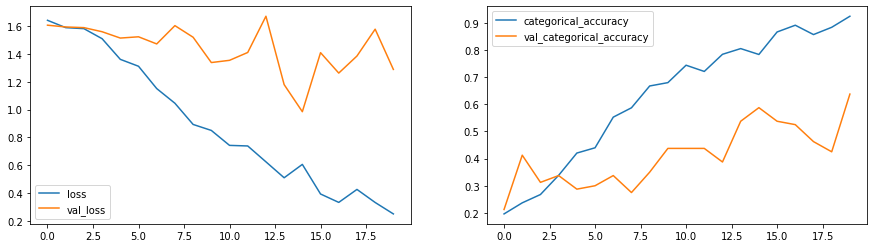

In [24]:
plot_accuracy_and_loss(training_cnn_rnn_model)

## Observation Model 4 - TimeDistributed Conv2D + LSTM
- categorical_accuracy: 0.9241
- val_accuracy: 0.6375
- Train accuracy has improved further but overfitting introduced

# Model 5 :- TimeDistributed Conv2D + LSTM
- Conv2D (16, 32, 64, 128)
- LSTM (128)
- Dense ( 128, 128, 5)
- Hyperparameter frames_to_sample=30, batch_size=20, num_epochs=20

In [31]:
class CNNRNNModel_LSTM_2(ModelBuilderClass):

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        optimiser = Adam(learning_rate=0.0002)
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [32]:
conv_cnn_rnn_lstm = CNNRNNModel_LSTM_2(file_start="5_cnn-rnn-lstm_model_")
conv_cnn_rnn_lstm.initialize_path(project_folder)
conv_cnn_rnn_lstm.initialize_image_properties(image_height=160, image_width=160)
conv_cnn_rnn_lstm.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=20)
conv_cnn_rnn_lstm.generator(conv_cnn_rnn_lstm.val_path, conv_cnn_rnn_lstm.val_doc, augment=True)
conv_cnn_rnn_lstm_model = conv_cnn_rnn_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_cnn_rnn_lstm_model.summary()

# training sequences = 663
# validation sequences = 100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 dropout_21 (Dropout)        (None, 30, 80, 80, 16)    0         
                                                                 
 time_distributed_32 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 40, 40, 32)   0        

In [33]:
training_cnn_rnn_lstm_model  = conv_cnn_rnn_lstm.train_model(conv_cnn_rnn_lstm_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6659 - categorical_accuracy: 0.1685Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.61042, saving model to 5_cnn-rnn-lstm_model__2023-12-3114_31_45.773419/model-00001-1.66590-0.16852-1.61042-0.22500.h5
27/27 [==============================] - 119s 4s/step - loss: 1.6659 - categorical_accuracy: 0.1685 - val_loss: 1.6104 - val_categorical_accuracy: 0.2250 - lr: 2.0000e-04
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6173 - categorical_accuracy: 0.2447
Epoch 00002: val_loss improved from 1.61042 to 1.60829, saving model to 5_cnn-rnn-lstm_model__2023-12-3114_31_45.773419/model-00002-1.61732-0.24474-1.60829-0.23750.h5
27/27 [==============================] - 111s 4s/step - loss: 1.6173 - categorical_accuracy: 0.2447 - val_loss: 1.6083 - val_categorical_accuracy: 0.2375 - lr: 2.000

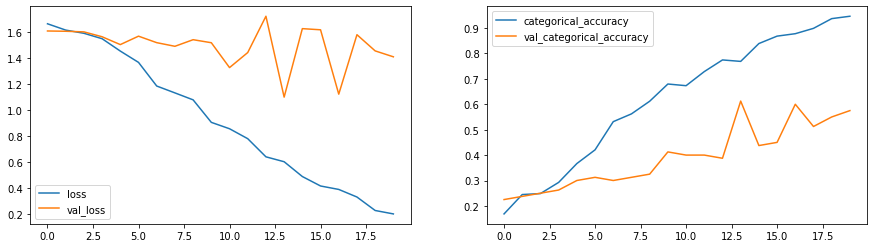

In [34]:
plot_accuracy_and_loss(training_cnn_rnn_lstm_model)

## Observation Model 5 - TimeDistributed Conv2D + LSTM
- train_accuracy - 0.9463
- val_accuracy - 0.5750
- Training improved but overfitting is still huge

# Model 6 :- TimeDistributed Conv2D + GRU
- Conv2D (16, 32, 64, 128)
- GRU (128)
- Dense (128)
- Hyperparameter frames_to_sample=30, batch_size=20, num_epochs=20

In [12]:
class CNNRNNModel_GRU(ModelBuilderClass):
       

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        optimiser = Adam(learning_rate=0.0002)
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.4))

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.4))

        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model


In [13]:
conv_cnn_gru = CNNRNNModel_GRU(file_start = "6_CNNRNNModel_GRU_")
conv_cnn_gru.initialize_path(project_folder)
conv_cnn_gru.initialize_image_properties(image_height=160, image_width=160)
conv_cnn_gru.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=20)
conv_cnn_gru.generator(conv_cnn_gru.val_path, conv_cnn_gru.val_doc, augment=True)
conv_cnn_gru_model = conv_cnn_gru.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_cnn_gru_model.summary()

# training sequences = 663
# validation sequences = 100


2023-12-30 16:48:49.874231: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-30 16:48:49.874303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 160, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 80, 80, 16)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 30, 80, 80, 16)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 80, 80, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 40, 40, 32)   0         
 tributed)                                              

In [14]:
training_cnn_gru_model  = conv_cnn_gru.train_model(conv_cnn_gru_model)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20


2023-12-30 16:49:09.752141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 1.6841 - categorical_accuracy: 0.2148Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.60516, saving model to 6_CNNRNNModel_GRU__2023-12-3016_48_57.007876/model-00001-1.68413-0.21481-1.60516-0.32500.h5
27/27 [==============================] - 279s 11s/step - loss: 1.6841 - categorical_accuracy: 0.2148 - val_loss: 1.6052 - val_categorical_accuracy: 0.3250 - lr: 2.0000e-04
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6044 - categorical_accuracy: 0.2314
Epoch 00002: val_loss improved from 1.60516 to 1.60405, saving model to 6_CNNRNNModel_GRU__2023-12-3016_48_57.007876/model-00002-1.60436-0.23136-1.60405-0.30000.h5
27/27 [==============================] - 246s 9s/step - loss: 1.6044 - categorical_accuracy: 0.2314 - val_loss: 1.6040 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.56

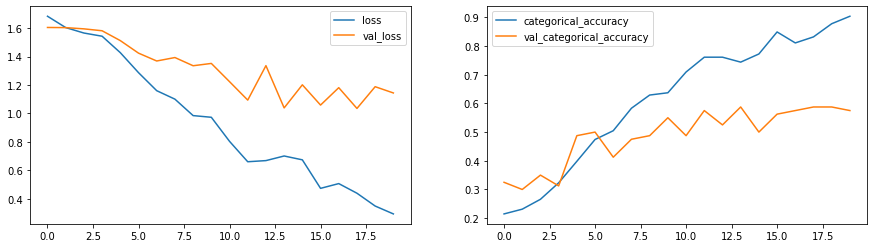

In [15]:
plot_accuracy_and_loss(training_cnn_gru_model)

## Observation Model 6 - TimeDistributed Conv2D + GRU
- train_accuracy - 0.9037
- val_accuracy - 0.5750
- Training improved but overfitting is observed

# Model 7 :- TimeDistributed Conv2D + GRU
- Conv2D (16, 32, 64)
- GRU (128)
- Dense (128, 128)
- Hyperparameter frames_to_sample=30, batch_size=20, num_epochs=20

In [27]:
class CNNRNNModel_GRU_2(ModelBuilderClass):       

    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        optimiser = Adam(learning_rate=0.0002)
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.4))

        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

In [28]:
conv_cnn_gru_2 = CNNRNNModel_GRU_2(file_start = "7_CNNRNNModel_GRU__2")
conv_cnn_gru_2.initialize_path(project_folder)
conv_cnn_gru_2.initialize_image_properties(image_height=160, image_width=160)
conv_cnn_gru_2.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=20)
conv_cnn_gru_2.generator(conv_cnn_gru_2.val_path, conv_cnn_gru_2.val_doc, augment=True)
conv_cnn_gru_model_2 = conv_cnn_gru_2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_cnn_gru_model_2.summary()

# training sequences = 663
# validation sequences = 100
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 dropout_17 (Dropout)        (None, 30, 80, 80, 16)    0         
                                                                 
 time_distributed_25 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 30, 40, 40, 32)   0        

In [29]:
training_cnn_gru_model_2  = conv_cnn_gru_2.train_model(conv_cnn_gru_model_2)

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.7003 - categorical_accuracy: 0.1870Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.59797, saving model to 7_CNNRNNModel_GRU__2_2023-12-3113_50_28.858863/model-00001-1.70034-0.18704-1.59797-0.28750.h5
27/27 [==============================] - 103s 4s/step - loss: 1.7003 - categorical_accuracy: 0.1870 - val_loss: 1.5980 - val_categorical_accuracy: 0.2875 - lr: 2.0000e-04
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5759 - categorical_accuracy: 0.2830
Epoch 00002: val_loss improved from 1.59797 to 1.55971, saving model to 7_CNNRNNModel_GRU__2_2023-12-3113_50_28.858863/model-00002-1.57589-0.28298-1.55971-0.32500.h5
27/27 [==============================] - 99s 4s/step - loss: 1.5759 - categorical_accuracy: 0.2830 - val_loss: 1.5597 - val_categorical_accuracy: 0.3250 - lr: 2.0000e-

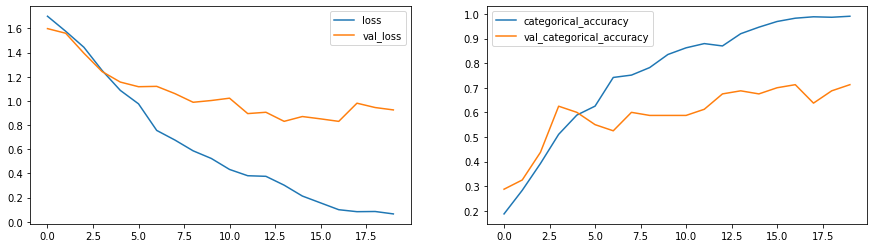

In [30]:
plot_accuracy_and_loss(training_cnn_gru_model_2)

## Observation Model 7 - TimeDistributed Conv2D + GRU
- train_accuracy - 0.9907
- val_accuracy - 0.7125
- Training improved but overfitting is still huge

# Model 8 :-  TimeDistributed Conv2D + BatchNormalization + LSTM2D + GlobalAveragePooling2D
- Conv2D ( 8, 16)
- ConvLSTM2D ( 8)
- GlobalAveragePooling2D
- Dense ( 64, 5)
- Hyperparameter frames_to_sample=30, batch_size=20, num_epochs=50

In [20]:
class CNN_Final(ModelBuilderClass):   
        
       
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):
        optimiser = Adam(learning_rate=0.0002)
        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'))        )
        model.add(BatchNormalization())
        model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False)        )        
        model.add(BatchNormalization())        
        model.add(TimeDistributed(Dense(64, activation='relu'))        )        
        model.add(BatchNormalization())        
        model.add(GlobalAveragePooling2D())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    

In [62]:
conv_final = CNN_Final(file_name="8_CNN_Final_")
conv_final.initialize_path(project_folder)
conv_final.initialize_image_properties(image_height=160, image_width=160)
conv_final.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=50)
conv_final.generator(conv_final.val_path, conv_final.val_doc, augment=True)
conv_final_model = conv_final.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
conv_final_model.summary()



# training sequences = 663
# validation sequences = 100
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 30, 158, 158, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 158, 158, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 156, 156, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_9 (Batc  (None, 30, 156, 156, 16)  64       
 hNormalization)                                                 
                                                               

In [63]:
training_final_model  = conv_final.train_model(conv_final_model)


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.5555 - categorical_accuracy: 0.3426Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2023-12-2911_58_08.179213/model-00001-1.55552-0.34259-1.60907-0.18750.h5
27/27 [==============================] - 118s 4s/step - loss: 1.5555 - categorical_accuracy: 0.3426 - val_loss: 1.6091 - val_categorical_accuracy: 0.1875 - lr: 2.0000e-04
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.4702 - categorical_accuracy: 0.4264
Epoch 00002: saving model to model_init_2023-12-2911_58_08.179213/model-00002-1.47021-0.42639-1.60320-0.23750.h5
27/27 [==============================] - 97s 4s/step - loss: 1.4702 - categorical_accuracy: 0.4264 - val_loss: 1.6032 - val_categorical_accuracy: 0.2375 - lr: 2.0000e-04
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.4162 - categorical_accuracy: 

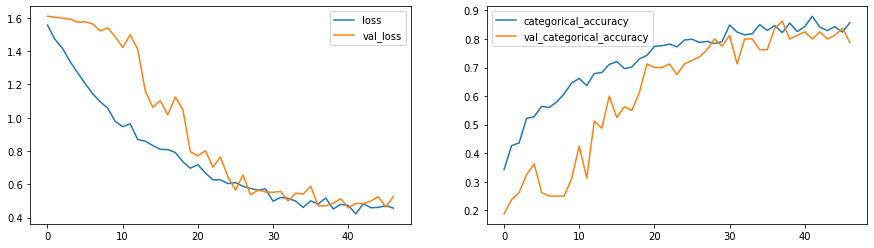

In [ ]:
plot_accuracy_and_loss(training_final_model)

## Observation for Model 8 -  TimeDistributed Conv2D + BatchNormalization + LSTM2D + GlobalAveragePooling2D
- train_accuracy - 0.8566
- val_accuracy - 0.7875
- Training improved but some overfitting is observed

# Model 9 :-  Conv3D + GlobalAveragePooling3D
- Conv3D (32, 64)
- GlobalAveragePooling3D
- Dense (128, 5)
- Hyperparameter frames_to_sample=30, batch_size=20, num_epochs=50

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, GlobalAveragePooling3D, Dense
class ImprovedCNN(ModelBuilderClass):
                
    def define_model(self, lstm_cells=64, dense_neurons=64, dropout=0.25):

        # Create a Sequential model
        model = Sequential()

        # Add a 3D convolutional layer with BatchNormalization
        model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(BatchNormalization())

        # Add another 3D convolutional layer with BatchNormalization
        model.add(Conv3D(64, (3, 3, 3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(BatchNormalization())

        # Add GlobalAveragePooling3D layer
        model.add(GlobalAveragePooling3D())

        # Add a Dense layer
        model.add(Dense(128, activation='relu'))

        # Output layer
        model.add(Dense(5, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        # Display the model summary
        model.summary()

        return model


In [22]:


conv_final_gl_avg_pl3d = ImprovedCNN(file_start = "9_GlobalAveragePooling2D_")
conv_final_gl_avg_pl3d.initialize_path(project_folder)
conv_final_gl_avg_pl3d.initialize_image_properties(image_height=160, image_width=160)
conv_final_gl_avg_pl3d.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=50)
conv_final_gl_avg_pl3d.generator(conv_final_gl_avg_pl3d.val_path, conv_final_gl_avg_pl3d.val_doc, augment=True)
conv_final_gl_avg_pl3d_model = conv_final_gl_avg_pl3d.define_model(lstm_cells=64,dense_neurons=64,dropout=0.25)
conv_final_gl_avg_pl3d_model.summary()



# training sequences = 663
# validation sequences = 100
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 28, 158, 158, 32)  2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 79, 79, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 12, 77, 77, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 6, 38, 38, 64)    0         
 3D)                                                             
                                                                 
 global_average_pooling3d_4   (None, 64)               0         
 (GlobalAveragePooling3D)                                       

Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.6130 - categorical_accuracy: 0.2185Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.59945, saving model to 9_GlobalAveragePooling2D__2023-12-3106_46_52.138640/model-00001-1.61298-0.21852-1.59945-0.27500.h5
27/27 [==============================] - 220s 8s/step - loss: 1.6130 - categorical_accuracy: 0.2185 - val_loss: 1.5994 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.5897 - categorical_accuracy: 0.2333
Epoch 00002: val_loss improved from 1.59945 to 1.57781, saving model to 9_GlobalAveragePooling2D__2023-12-3106_46_52.138640/model-00002-1.58969-0.23327-1.57781-0.30000.h5
27/27 [==============================] - 207s 8s/step - loss: 1.5897 - categorical_accuracy: 0.2333 - val_loss: 1.5778 - val_categorical_accuracy: 0.3000 - lr: 0

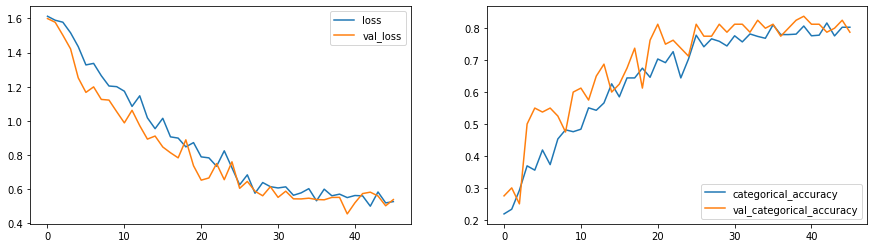

In [23]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

training_final_model  = conv_final_gl_avg_pl3d.train_model(conv_final_gl_avg_pl3d_model)

plot_accuracy_and_loss(training_final_model)

## Observation for Model 9 - Conv3D + GlobalAveragePooling2D
- train_accuracy - 0.8031
- val_accuracy - 0.7875
- Training improved and overfitting also reduced

# Model 10 :- Transfer Learning using TimeDistributed BatchNormalization MobileNet and GRU

 - TimeDistributed MobileNet
 - GRU
 - Dense(128, 5)
 - Hyperparameter frames_to_sample=30, batch_size=5, num_epochs=50


2023-12-31 12:54:55.711174: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-31 12:54:55.711234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


# training sequences = 663
# validation sequences = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 5, 5, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 5, 5, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 2, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4096)         0         
 tributed)                                                       
                                                                 


2023-12-31 12:55:04.368208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 1.5297 - categorical_accuracy: 0.3556Source path =  /datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 1.38550, saving model to 11_transfer_learning_gru__2023-12-3112_54_57.369450/model-00001-1.52970-0.35556-1.38550-0.50000.h5
27/27 [==============================] - 95s 3s/step - loss: 1.5297 - categorical_accuracy: 0.3556 - val_loss: 1.3855 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.3919 - categorical_accuracy: 0.4222
Epoch 00002: val_loss improved from 1.38550 to 1.24013, saving model to 11_transfer_learning_gru__2023-12-3112_54_57.369450/model-00002-1.39195-0.42222-1.24013-0.55000.h5
27/27 [==============================] - 111s 4s/step - loss: 1.3919 - categorical_accuracy: 0.4222 - val_loss: 1.2401 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1

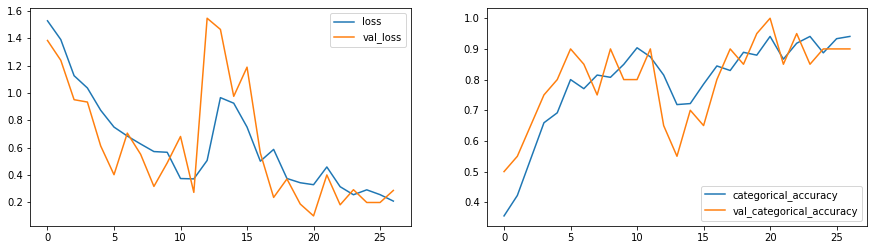

In [9]:
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Flatten, GRU, Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv3D, BatchNormalization, MaxPooling2D, Flatten, GRU, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from keras.applications import mobilenet

tf.keras.backend.clear_session()
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


class Transfer_Learning_GRU(ModelBuilderClass):       

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

        
# # Instantiate and train the improved model
improved_cnn_final = Transfer_Learning_GRU(file_start="10_Transfer_Learning_GRU_")
improved_cnn_final.initialize_path(project_folder)
improved_cnn_final.initialize_image_properties(image_height=160, image_width=160)
improved_cnn_final.initialize_hyperparams(frames_to_sample=30, batch_size=5, num_epochs=50)

# Generate data generator for validation
improved_cnn_final.generator(improved_cnn_final.val_path, improved_cnn_final.val_doc, augment=True)

# Define and print model summary
improved_cnn_final_model = improved_cnn_final.define_model(gru_cells=64, dense_neurons=64, dropout=0.25)
improved_cnn_final_model.summary()

tf.keras.backend.clear_session()

# Train the model
training_final_model = improved_cnn_final.train_model(improved_cnn_final_model)

# Plot accuracy and loss
plot_accuracy_and_loss(training_final_model)


### Observation for Transfer Learning using TimeDistributed BatchNormalization MobileNet and GRU

- train_accuracy - 0.9407
- val_accuracy - 0.9000
- Training improved and overfitting is not there


# Conclusion
- Model created using transfer learning has best accuracy for both train and validation.
Hence final model.h5 created using the same